# Importing libraries

In [1]:
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks, freqz
from scipy.io.wavfile import write
from librosa import feature 
from hmmlearn import hmm

In [122]:
pathToData = r"C:\\Users\\HP\\Downloads\\Commands Dataset"
pathToTrainingData = pathToData+"\\train"
pathToCleanTest = pathToData+"\\test_clean"
pathToNoisyTest = pathToData+"\\test_noisy"

# Reading and pre-processing the data

## Pre emphasis

Applying pre-emphasis to the signal

We can do this by passing the signal througha filter : 
$$H(z) = (1 - \alpha z^{-1}) \text{ with $\alpha$ very close to 1, typically = 0.95}$$
$$\implies y[n] = x[n] - \alpha x[n-1]$$

In [3]:
def applyPreEmphasis(data, alpha = 0.95):
    alpha = 0.95#choosing the zero for pre-emphasis
    dataPreEmph = np.array([data[n] - alpha*data[n-1] for n in range(1, len(data))])#gives singal from n=1 since we start from 1
    dataPreEmph = np.insert(dataPreEmph, 0, data[0])#intial value is same as that of x[0]
    return dataPreEmph

## Reading and storing data

In [4]:
trainingData = {}
for label in os.listdir(pathToTrainingData):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToTrainingData+"\\"+label):
        sampleRate, data = wavfile.read(pathToTrainingData+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    trainingData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


In [5]:
testCleanData = {}
for label in os.listdir(pathToCleanTest):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToCleanTest+"\\"+label):
        sampleRate, data = wavfile.read(pathToCleanTest+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    testCleanData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


In [123]:
testNoisyData = {}
for label in os.listdir(pathToNoisyTest):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToNoisyTest+"\\"+label):
        sampleRate, data = wavfile.read(pathToNoisyTest+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    testNoisyData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


---

## Implementing end pointing of speech signal

For this, I have used thresholding of normalised power spectra to first identify where speech has occured and then used this to find the entire length of the actual utterance.

$$\text{Normalised power} \; P_N = 10 \times log_{10} \left ( \frac{E}{E_{max}} \right)$$

$$\text{Speech detected} \; S = \begin{cases}
      1, & \text{if}\ P_N>=Threshold \\
      0, & \text{otherwise}
    \end{cases}$$

After observing the speech patterns accross many words and utterances, $threshold\;=\;-40$ gives good end-pointing.

In [102]:
def energyNormalised(data, sampleRate, dur = 0.02):
    '''
    returns the power spectrum of the signal noramalised and the zero crossing rate of the signal'''
    samples = int(sampleRate*dur) #length of each sample
    ham = np.hamming(samples)
    zcr = []
    energy = []
    halfSample = samples//2
    paddedData = np.pad(data, (halfSample, halfSample), 'constant')#padding the signal
    #pad the signal with halfsamples 0 ahead and before. then iterate over the indices point by point for thresholding
    for i in range(halfSample, data.shape[0]):
        signalAfterhamming = paddedData[i-halfSample:i+halfSample]*ham #sampling each fram 20ms long
        #zcr.append((signalAfterhamming[:-1]*signalAfterhamming[1:]<0).sum())
        energy.append(np.sum(signalAfterhamming*signalAfterhamming)) #energy of the signal
    #returning normalised power spectrum of the signal
    finenergy = np.where(np.array(energy) > 0.000000000000000000001, np.array(energy), -20) #thresholding to prevent log10 zero runtime warning
    if max(finenergy)==0:
        return 10*np.log10(finenergy, out=finenergy, where=finenergy > 0), np.array(zcr)
    else:
        return 10*np.log10(finenergy/max(finenergy), out=finenergy/max(finenergy), where=finenergy/max(finenergy) > 0), np.array(zcr)

In [96]:
def vad(powerSpectrum, threshold):
    flag = []
    for i in powerSpectrum:
        if i>=threshold:
            flag.append(1.0)
        else:
            flag.append(0.0)
    return np.array(flag)

In [97]:
def voiceDetected(data, sampleRate, threshold, dur = 0.02):
    power, _ = energyNormalised(data, sampleRate=sampleRate, dur = dur)
    indSpeech = vad(power, threshold)
    inds = np.where(indSpeech== 1)
    return data[inds[0][0]:inds[0][-1]]

In [98]:
trainingLabels

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

Text(0, 0.5, 'Amplitude')

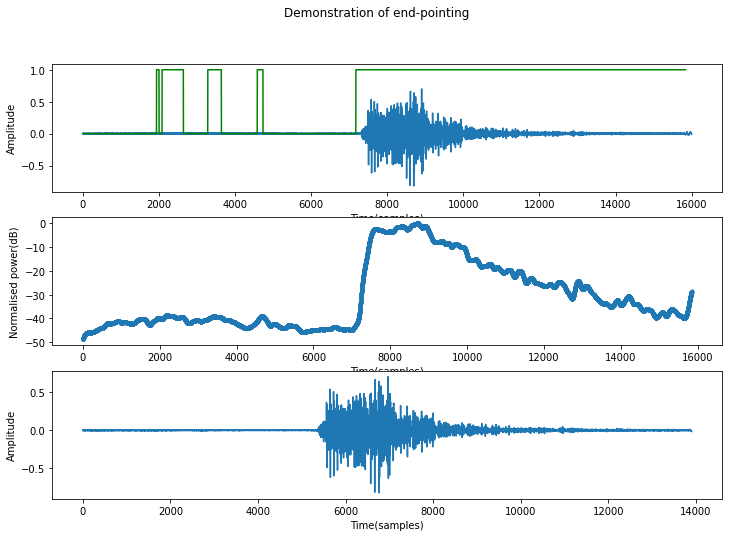

In [121]:
plt.figure(figsize = (12, 8))
plt.suptitle("Demonstration of end-pointing")
plt.tight_layout(pad=100)
index = np.random.randint(1, 100)
sig = trainingData["up"][index]
e, _ = energyNormalised(sig, sampleRate=sampleRate)
plt.subplot(311)
plt.plot(sig, label = "signal(true)")
plt.plot(vad(e, -40), 'g', label = "speech detection")
plt.xlabel("Time(samples)")
plt.ylabel("Amplitude")
plt.subplot(312)
plt.plot(e, '.',label = "Normalised power spectrum")
plt.xlabel("Time(samples)")
plt.ylabel("Normalised power(dB)")
plt.subplot(313)
plt.plot(voiceDetected(sig, sampleRate, -40, dur = 0.02), label = "End- pointed speech")
plt.xlabel("Time(samples)")
plt.ylabel("Amplitude")


---

## Pre-processing the input data - train and test(clean)

In [103]:
trainingLabels = [label for label in os.listdir(pathToTrainingData)]
trainingDataPreProcessed = {}
for label in trainingLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(trainingData[label])):
        soundLabelAsArray.append(applyPreEmphasis(voiceDetected(trainingData[label][i], sampleRate,  threshold=-40, dur = 0.02), alpha = 0.95))
    trainingDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


In [104]:
testCleanLabels = [label for label in os.listdir(pathToCleanTest)]
cleanTestDataPreProcessed = {}
for label in testCleanLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(testCleanData[label])):
        soundLabelAsArray.append(applyPreEmphasis(voiceDetected(testCleanData[label][i], sampleRate,  threshold=-40, dur = 0.02), alpha = 0.95))
    cleanTestDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


In [124]:
testNoisyLabels = [label for label in os.listdir(pathToNoisyTest)]
noisyTestDataPreProcessed = {}
for label in testNoisyLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(testNoisyData[label])):
        soundLabelAsArray.append(applyPreEmphasis(voiceDetected(testNoisyData[label][i], sampleRate,  threshold=-40, dur = 0.02), alpha = 0.95))
    noisyTestDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


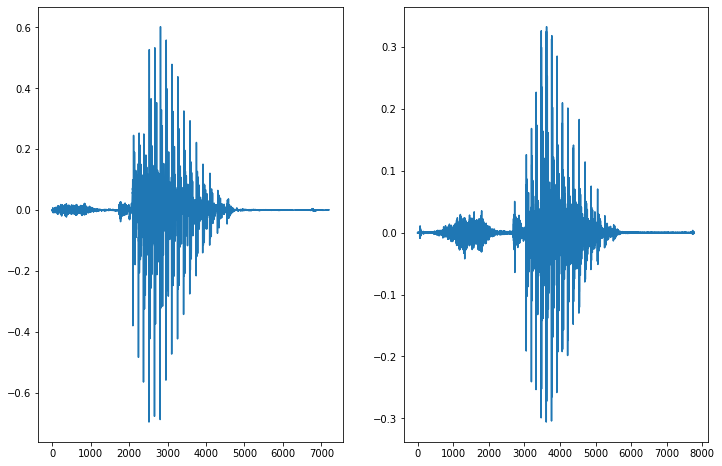

In [105]:
plt.figure(figsize=(12, 8))
str = "stop"
indx = 90
plt.subplot(121)
plt.plot(end_pointing(trainingData[str][indx],sampleRate))
plt.subplot(122)
plt.plot(trainingDataPreProcessed[str][indx])

## MFCC feature extraction

I have used the librosa library inate functions to compute the mfcc feature vector for each of the signal.

Although its fast, it does not give me control over the windowing and frame length.

In [106]:
melCoef = {}
for label in trainingLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(trainingDataPreProcessed[label])):
        #n_fft = 4096, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate) set this parameters later
        mfccFeatures = feature.mfcc(y=trainingDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13)
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=2, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoef[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		....finished
Finding mel filter bank output for each instace of 'left' speech data		....finished
Finding mel filter bank output for each instace of 'no' speech data		....finished
Finding mel filter bank output for each instace of 'off' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1208
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'on' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1755
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'right' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1727
  return f(*args, **kwargs)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=841
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'stop' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=999
  return f(*args, **kwargs)


....finished
Finding mel filter bank output for each instace of 'up' speech data		....finished
Finding mel filter bank output for each instace of 'yes' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1269
  return f(*args, **kwargs)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=357
  return f(*args, **kwargs)


....finished


In [107]:
melCoefCleanTest = {}
for label in testCleanLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(cleanTestDataPreProcessed[label])):
        #n_fft = 4096, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate) set this parameters later
        mfccFeatures = feature.mfcc(y=cleanTestDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13)
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=2, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoefCleanTest[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		....finished
Finding mel filter bank output for each instace of 'left' speech data		....finished
Finding mel filter bank output for each instace of 'no' speech data		....finished
Finding mel filter bank output for each instace of 'off' speech data		....finished
Finding mel filter bank output for each instace of 'on' speech data		....finished
Finding mel filter bank output for each instace of 'right' speech data		....finished
Finding mel filter bank output for each instace of 'stop' speech data		....finished
Finding mel filter bank output for each instace of 'up' speech data		....finished
Finding mel filter bank output for each instace of 'yes' speech data		....finished


In [125]:
melCoefNoisyTest = {}
for label in testNoisyLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(noisyTestDataPreProcessed[label])):
        #n_fft = 4096, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate) set this parameters later
        mfccFeatures = feature.mfcc(y=noisyTestDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13)
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=2, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoefNoisyTest[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		....finished
Finding mel filter bank output for each instace of 'left' speech data		....finished
Finding mel filter bank output for each instace of 'no' speech data		....finished
Finding mel filter bank output for each instace of 'off' speech data		....finished
Finding mel filter bank output for each instace of 'on' speech data		....finished
Finding mel filter bank output for each instace of 'right' speech data		....finished
Finding mel filter bank output for each instace of 'stop' speech data		....finished
Finding mel filter bank output for each instace of 'up' speech data		....finished
Finding mel filter bank output for each instace of 'yes' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1269
  return f(*args, **kwargs)


....finished


In [28]:
trainingLabels

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

[Text(0.5, 1.0, 'MFCC')]

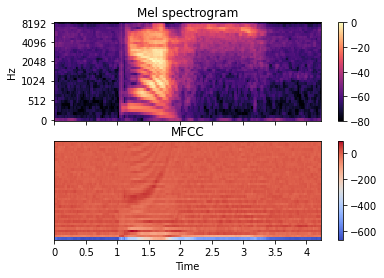

In [108]:
import librosa
import librosa.display
dur = 0.01
y, sr = trainingDataPreProcessed["yes"][90], sampleRate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate),
                                   fmax=8000)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate))
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

In [29]:
np.vstack((np.array([1,2, 3]),np.array([[1,2, 6], [1,2, 8]])))

array([[1, 2, 3],
       [1, 2, 6],
       [1, 2, 8]])

In [152]:
melCoef["down"][0].shape

(17, 39)

In [157]:
curr_train = melCoef["down"][0].T
for i in range(1, len(melCoef["down"])):
    curr_train = np.vstack((curr_train, melCoef["down"][i].T))

# Training the models for each word

I was not able to come with model parameters on my own. I discussed with friends for choosing optimal paramters since the trianing times for GMM-HMM models were too big

In [108]:
trained_model = {}
hmmStates = 9
gmmStates = 3

print(melCoef.keys())

for word in melCoef.keys():
    print(word)
    #model = hmm.GaussianHMM(n_components = hmm_states, covariance_type='full', n_iter=7)
    model = hmm.GMMHMM(n_components=hmmStates, n_mix = gmmStates, n_iter=10 , covariance_type='full' )
    current_training_data = melCoef[word]
    l = np.zeros([len(current_training_data), ], dtype=int)
    i = 0

    while i < int(len(current_training_data)):
        l[i] = current_training_data[i].shape[1]
        i += 1
    curr_train = melCoef[word][0].T
    for i in range(1, len(melCoef[word])):
        curr_train = np.vstack((curr_train, melCoef[word][i].T))
    
    #current_training_data = np.vstack(current_training_data)
    model.fit(curr_train, lengths=l)
    trained_model[word] = model

dict_keys(['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes'])
down
go
left
no
off
on
right
stop
up
yes


# Prediction

## Predicition on clean data

In [109]:
finalPredictedClean = {}
for utt in melCoef.keys():
    scores = []
    for i in range(len(melCoefCleanTest[utt])):
        logList = []
        for word in melCoef.keys():
            logList.append(trained_model[word].score(melCoefCleanTest[utt][i].T))
        scores.append(list(melCoef.keys())[logList.index(max(logList))])
    finalPredictedClean[utt] = scores

## Prediction on noisy data

In [126]:
finalPredictedNoisy = {}
for utt in melCoef.keys():
    scores = []
    for i in range(len(melCoefNoisyTest[utt])):
        logList = []
        for word in melCoef.keys():
            logList.append(trained_model[word].score(melCoefNoisyTest[utt][i].T))
        scores.append(list(melCoef.keys())[logList.index(max(logList))])
    finalPredictedNoisy[utt] = scores

# Calculating accuracies

## Computing the accuracies for each word classification

In [110]:
finalAccuraciesClean = {}
for utt in melCoef.keys():
    accPred = []
    for word in melCoef.keys():
        acc = 0
        for i in finalPredictedClean[utt]:
            if i==word:
                acc+=1
        accPred.append(acc/len(melCoefCleanTest[utt]))
    finalAccuraciesClean[utt] = accPred

In [127]:
finalAccuraciesNoisy = {}
for utt in melCoef.keys():
    accPred = []
    for word in melCoef.keys():
        acc = 0
        for i in finalPredictedNoisy[utt]:
            if i==word:
                acc+=1
        accPred.append(acc/len(melCoefNoisyTest[utt]))
    finalAccuraciesNoisy[utt] = accPred

In [111]:
import pandas as pd

df = pd.DataFrame.from_dict(finalAccuraciesClean)
df

,down,go,left,no,off,on,right,stop,up,yes
0,0.960474,0.003984,0.003745,0.015873,0.000000,0.004065,0.007722,0.004016,0.0,0.000000
1,0.011858,0.980080,0.000000,0.039683,0.000000,0.004065,0.007722,0.004016,0.0,0.000000
2,0.003953,0.000000,0.981273,0.007937,0.003817,0.000000,0.000000,0.000000,0.0,0.003906
3,0.023715,0.015936,0.003745,0.928571,0.007634,0.000000,0.003861,0.008032,0.0,0.003906
4,0.000000,0.000000,0.000000,0.000000,0.958015,0.004065,0.000000,0.000000,0.0,0.000000
5,0.000000,0.000000,0.000000,0.003968,0.015267,0.975610,0.000000,0.000000,0.0,0.003906
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980695,0.000000,0.0,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.983936,0.0,0.000000
8,0.000000,0.000000,0.007491,0.003968,0.015267,0.012195,0.000000,0.000000,1.0,0.000000
9,0.000000,0.000000,0.003745,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.988281


In [128]:
dfNoisy = pd.DataFrame.from_dict(finalAccuraciesNoisy)
dfNoisy

,down,go,left,no,off,on,right,stop,up,yes
0,0.794466,0.055777,0.014981,0.103175,0.000000,0.036585,0.007722,0.004016,0.011029,0.007812
1,0.098814,0.848606,0.029963,0.246032,0.022901,0.052846,0.069498,0.080321,0.062500,0.007812
2,0.011858,0.007968,0.823970,0.019841,0.011450,0.004065,0.111969,0.016064,0.058824,0.027344
3,0.011858,0.007968,0.003745,0.543651,0.003817,0.000000,0.000000,0.004016,0.000000,0.000000
4,0.023715,0.023904,0.014981,0.027778,0.885496,0.138211,0.000000,0.040161,0.099265,0.015625
5,0.000000,0.007968,0.000000,0.000000,0.019084,0.743902,0.011583,0.000000,0.000000,0.011719
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.741313,0.000000,0.000000,0.000000
7,0.015810,0.027888,0.007491,0.015873,0.015267,0.004065,0.007722,0.835341,0.044118,0.003906
8,0.011858,0.007968,0.014981,0.011905,0.030534,0.020325,0.015444,0.008032,0.713235,0.007812
9,0.031621,0.011952,0.089888,0.031746,0.011450,0.000000,0.034749,0.012048,0.011029,0.917969


## Accuracy heatmaps

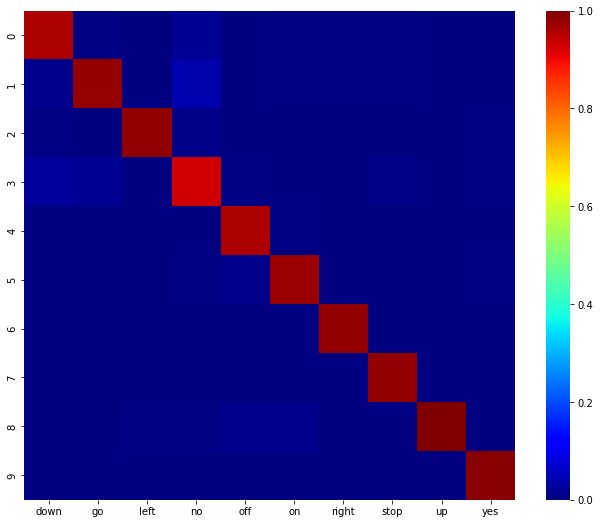

In [112]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df, cmap = 'jet')
plt.show()

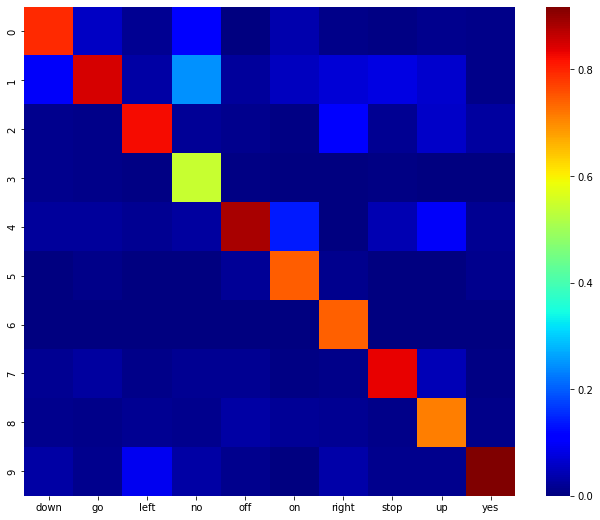

In [129]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(dfNoisy, cmap = 'jet')
plt.show()